In [8]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.prompts import ChatPromptTemplate
from langchain.memory import ConversationBufferMemory
from langchain.load import dumps, loads
from langchain import hub
from operator import itemgetter
import textwrap
from textwrap import dedent
# from langchain_experimental.text_splitter import SemanticChunker

from dotenv import load_dotenv
load_dotenv()

True

In [9]:
import shutil
import os
def reset_chroma_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)

In [11]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300, chunk_overlap=50)

# Knowledge Base 1: First Aid Guide
first_aid_path = "../knowledge/medical_knowledge/FA_CPR_AED_PM_sample_chapter.pdf"
first_aid_dir = "../knowledge/medical_knowledge/chroma_first_aid"
reset_chroma_directory(first_aid_dir)
loader_first_aid = PyMuPDFLoader(first_aid_path)
docs_first_aid = loader_first_aid.load()
splits_first_aid = text_splitter.split_documents(docs_first_aid)
vectorstore_first_aid = Chroma.from_documents(splits_first_aid, 
                                              embedding=OpenAIEmbeddings(),
                                              collection_name="first_aid_collection",
                                              persist_directory=first_aid_dir)
retriever_first_aid = vectorstore_first_aid.as_retriever()

# Knowledge Base 2: Condition of Victims
victim_conditions_path = "../knowledge/medical_knowledge/people_conditions_db.pdf"
victim_conditions_dir = "../knowledge/medical_knowledge/chroma_victim_conditions"
reset_chroma_directory(victim_conditions_dir)
loader_victim_conditions = PyMuPDFLoader(victim_conditions_path)
docs_victim_conditions = loader_victim_conditions.load()
splits_victim_conditions = text_splitter.split_documents(
    docs_victim_conditions)
vectorstore_victim_conditions = Chroma.from_documents(splits_victim_conditions,
                                                      embedding=OpenAIEmbeddings(),
                                                      collection_name="victim_conditions_collection",
                                                      persist_directory=victim_conditions_dir)
retriever_victim_conditions = vectorstore_victim_conditions.as_retriever()

# Knowledge Base 3: Triage Guide
triage_path = "../knowledge/medical_knowledge/traumatriage.pdf"
triage_dir = "../knowledge/medical_knowledge/chroma_triage"
reset_chroma_directory(triage_dir)
loader_triage = PyMuPDFLoader(triage_path)
docs_triage = loader_triage.load()
splits_triage = text_splitter.split_documents(docs_triage)
vectorstore_triage = Chroma.from_documents(splits_triage,
                                           embedding=OpenAIEmbeddings(),
                                           collection_name="triage_guide_collection",
                                           persist_directory=triage_dir)
retriever_triage = vectorstore_triage.as_retriever()

In [12]:
knowledge_bases = [
    {
        "id": "1",
        "name": "First Aid Guide",
        "description": "Emergency first aid, CPR, AED, general medical responses",
        "retriever": retriever_first_aid
    },
    {
        "id": "2",
        "name": "Victim Condition Database",
        "description": "History, conditions, symptoms, and personalized treatments for victims in the search and rescue task",
        "retriever": retriever_victim_conditions
    },
    {
        "id": "3",
        "name": "Trauma Triage Guide",
        "description": "Guidelines for the Appropriate Triage of a Victim of Trauma",
        "retriever": retriever_triage
    },
]

In [13]:
# Get relevant knowledge bases based on question. 
router_prompt_template = """
You are an AI assistant for search and rescue tasks that selects the most relevant knowledge base(s) to answer the serach and rescue (SAR) worker's question.

You have access to the following knowledge bases, each in the format of <id>. <name> (<description>):
{knowledge_bases}

SAR Worker Question: {question}

You may choose one or more knowledge bases by providing their IDs, separated by commas (e.g., "1" or "1,2" or "1,2,3" etc. depending on what knowledge bases you think will help answer the question).
If none are relevant, answer "none".

Output either the ID(s) (comma-separated) or "none":
"""
router_prompt = ChatPromptTemplate.from_template(router_prompt_template)

In [14]:
llm = ChatOpenAI(model="gpt-4o",temperature=0)

# Find which knowledge bases to pull information from. Use the retriever to get
# the most relevant docs from each in relation to the question. 
def get_relevant_docs(routing_response, question):
    selected_kb_ids = routing_response.content

    if selected_kb_ids == "none":
        return ""

    kb_ids = [kb_id for kb_id in selected_kb_ids.split(",")]

    all_docs = []
    for kb_id in kb_ids:
        for kb in knowledge_bases:
            if kb["id"] == kb_id:
                found_docs = kb["retriever"].invoke(question)
                all_docs.extend(found_docs)
    if not all_docs:
        return ""

    # Return only the unique docs. Future improvement could be to rank the docs
    # and return them in order of importance. 
    seen_contents = set()
    unique_docs = []
    for doc in all_docs:
        if doc.page_content not in seen_contents:
            unique_docs.append(doc)
            seen_contents.add(doc.page_content)

    merged_context = "\n\n".join(doc.page_content for doc in unique_docs)
    return merged_context

# Insert the knowledge base descriptions and user question to template and pass
# to the llm. 
retrieve_routing_response_chain = (
  {"knowledge_bases": itemgetter("knowledge_bases_strings"), 
   "question": itemgetter("question")}
   | router_prompt
   | llm
)

# Strings listing out each knowledge base to describe to the llm. 
knowledge_bases_strings = "\n".join(
    f"{kb['id']}. {kb['name']} ({kb['description']})" for kb in knowledge_bases
)

In [15]:
# Convert user question into sub questions. Future improvement could be to determine
# automatically the number of subquestions to create.
decomposition_prompt_template = """You are a helpful assistant that generates multiple sub-questions related to an input question.
The goal is to break down the input question into 3 queries that can be answered in isolation.
Generate 3 queries related to: {question}
Output (3 queries):"""

decomposition_prompt = ChatPromptTemplate.from_template(decomposition_prompt_template)

# Split the string of subquestions into list. 
generate_queries_decomposition_chain = (
    decomposition_prompt
    | llm
    | StrOutputParser()
    | (lambda x: x.split("\n"))
)

In [16]:
# Template to help answer main question given context of the knowledge bases as well
# as subquestion + answer pairs
final_prompt_template = dedent("""
Here is the question you need to answer:
---
{question}
---

Here is any available background question + answer pairs:
---
{q_a_pairs}
---

Here is additional context relevant to the question (from the knowledge bases):
---
{context}
---

Instructions:
1. If relevant context is found above, incorporate it into your answer.
2. If no relevant context is found from the knowledge bases, clearly mention that 
   there is no knowledge-base context, and then provide a normal, helpful answer 
   from your general knowledge (i.e., do NOT just say "I'm sorry ..."; still give a normal response).
""")

In [17]:
final_prompt = ChatPromptTemplate.from_template(final_prompt_template)

final_prompt_chain = (
    final_prompt
    | llm
)

def format_qa_pair(q: str, a: str) -> str:
    return f"Question: {q}\nAnswer: {a}\n"

In [18]:
# Implement user chat history as additional context. 
memory = ConversationBufferMemory(return_messages=True)

C:\Users\redki\AppData\Local\Temp\ipykernel_55768\1707426322.py:2: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(return_messages=True)


In [19]:
# Answer user question. Each subquestion will have the answer to the previous
# subquestion as context. Each subquestion will also have relevant docs from the
# knowledge base as context to answer the question. The main question will have
# the question and answer pairs from the subquestions and then context from the
# knowledge base to answer the main question. 

def answer_question(question):
    # Add use question to chat history
    memory.chat_memory.add_user_message(question)
    
    # Grab chat history
    conversation_history = memory.load_memory_variables({})

    # Convert chat history into readable format
    conversation_history_string = ""
    if conversation_history["history"]:
        messages = conversation_history["history"]
        for msg in messages:
            if hasattr(msg, 'content') and hasattr(msg, 'type'):
                prefix = "User: " if msg.type == 'human' else "Assistant: "
                conversation_history_string += f"{prefix}{msg.content}\n"

    # Get subquestions for the main question
    subquestions = generate_queries_decomposition_chain.invoke({"question": question})

    # Answer and add subquestion and answer pairs to the context.
    q_a_pairs = ""
    for subquestion in subquestions:
        routing_response = retrieve_routing_response_chain.invoke({"knowledge_bases_strings": knowledge_bases_strings,"question": subquestion})
        # Knowledge base docs only for the current subquestion.
        subquestion_context = get_relevant_docs(routing_response, subquestion)

        if not subquestion_context:
            subquestion_context = "No relevant context found"
        
        context_with_history = f"{subquestion_context}\n\nPrevious conversation:\n{conversation_history_string}"

        subanswer_response = final_prompt_chain.invoke({"question": subquestion, "q_a_pairs": q_a_pairs, "context": context_with_history}).content

        q_a_pairs += "\n---\n" + format_qa_pair(subquestion, subanswer_response)
    
    # Finally answer the main question given contexts.
    routing_response = retrieve_routing_response_chain.invoke({"knowledge_bases_strings": knowledge_bases_strings,"question": question})
    main_context = get_relevant_docs(routing_response, question)

    if not main_context:
        main_context = "No relevant context found"

    main_context = f"{main_context}\n\nPrevious conversation:\n{conversation_history_string}"

    # Knowledge base docs in the query will only be related to the main question.
    final_ans = final_prompt_chain.invoke({"question": question, "q_a_pairs": q_a_pairs, "context": main_context}).content

    memory.chat_memory.add_ai_message(final_ans)

    return final_ans

Model output about Rui Zhang follow the input correctly. Advice seems reasonable.
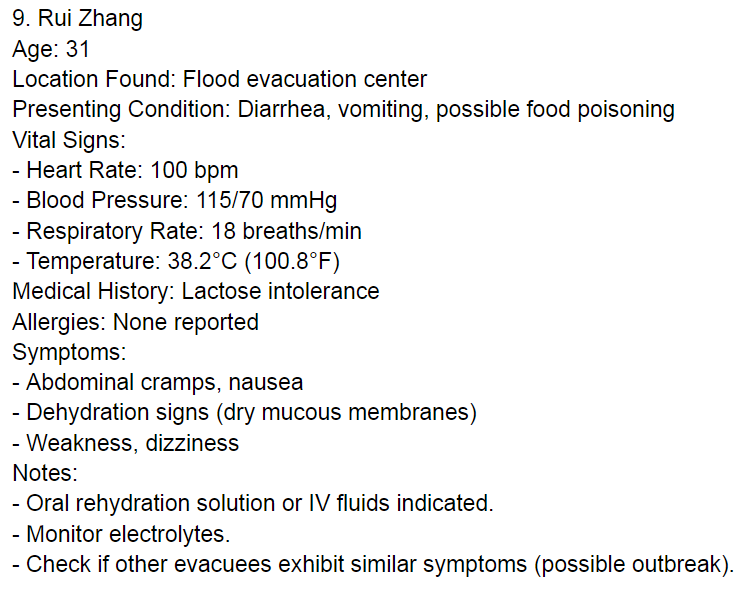

In [12]:
print(textwrap.fill(answer_question("Triage the victim Rui Zhang"), width=80))

Based on the information provided, Rui Zhang is experiencing symptoms consistent
with dehydration and possible food poisoning, including diarrhea, vomiting,
abdominal cramps, nausea, and a fever. His vital signs are stable, but his
condition requires attention to prevent further complications.  **Triage and
Immediate Care for Rui Zhang:**  1. **Priority Level:**    - Rui Zhang's
condition is concerning but not immediately life-threatening. He should be
prioritized for treatment after more critical cases, such as those with severe
allergic reactions or significant blood loss.  2. **Immediate Medical Needs:**
- **Rehydration:** Administer oral rehydration solutions if Rui can tolerate
them. If not, initiate IV fluids to address dehydration and maintain electrolyte
balance.    - **Symptom Management:** Provide medications for abdominal cramps
and nausea, ensuring they are suitable given Rui's lactose intolerance.    -
**Fever Management:** Administer antipyretics if necessary to manage Ru

Model output about Jane Doe follow the input correctly. Advice seems reasonable. 
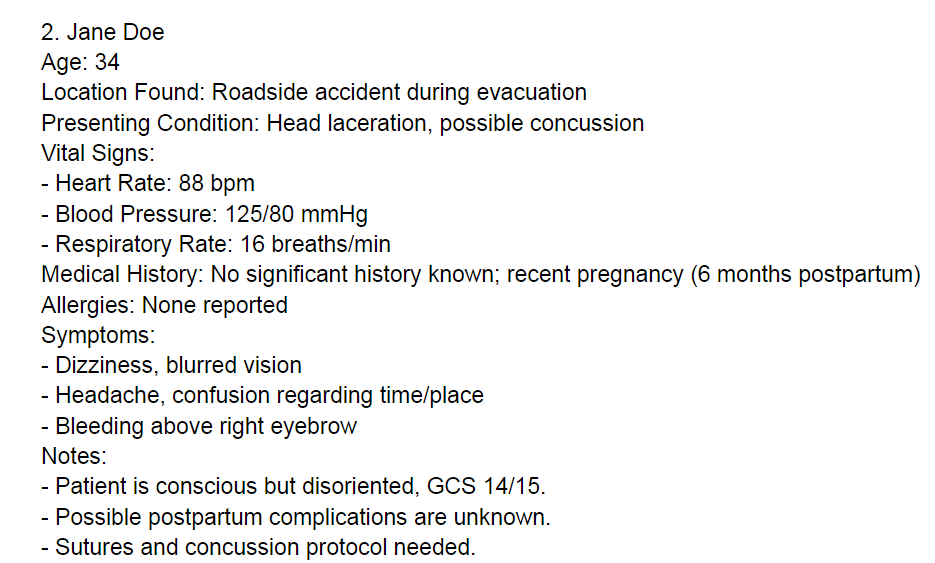

In [13]:
print(textwrap.fill(answer_question("Triage the victim Jane Doe"), width=80))

Based on the information provided, Jane Doe is a 34-year-old victim found at a
roadside accident with a head laceration and possible concussion. Her vital
signs are stable, but she is conscious and disoriented, with symptoms such as
dizziness, blurred vision, headache, and confusion. Her Glasgow Coma Scale (GCS)
score is 14/15, indicating mild disorientation.  **Triage and Immediate Care for
Jane Doe:**  1. **Priority Level:**    - Jane Doe should be prioritized for
immediate assessment and treatment due to the potential for a concussion and
head injury. This is crucial to prevent any complications from the head injury.
2. **Immediate Medical Needs:**    - **Head Injury Assessment:** Conduct a
thorough neurological examination to assess the severity of the concussion and
monitor for any signs of deterioration.    - **Wound Care:** Clean the head
laceration and apply sutures as needed to control bleeding and prevent
infection.    - **Concussion Protocol:** Implement concussion managemen

Model output about David Pérez follow the input correctly. Advice seems reasonable. 
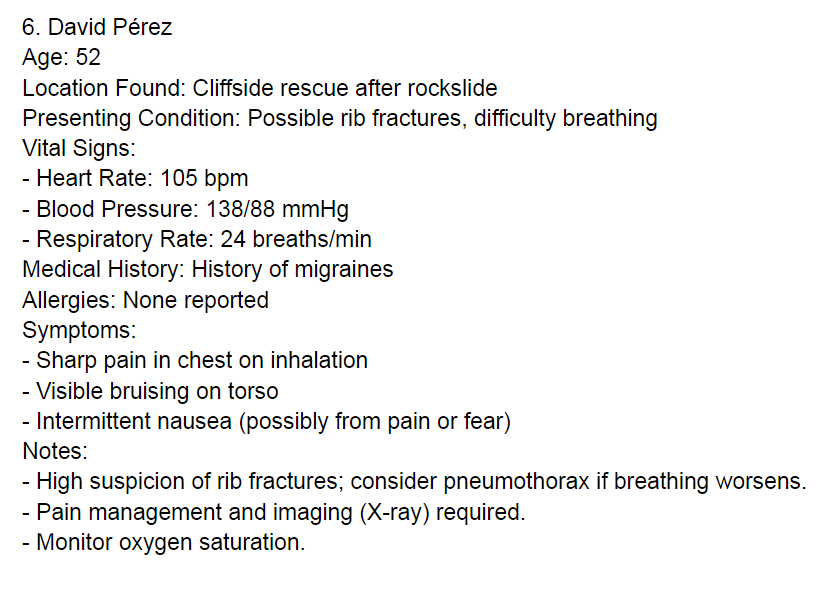

In [14]:
print(textwrap.fill(answer_question("Triage the victim David Pérez"), width=80))

Based on the information provided, David Pérez is a 52-year-old victim found
after a cliffside rescue following a rockslide. He presents with possible rib
fractures and difficulty breathing. His vital signs indicate a heart rate of 105
bpm, blood pressure of 138/88 mmHg, and a respiratory rate of 24 breaths/min,
suggesting he is experiencing some distress.  **Triage and Immediate Care for
David Pérez:**  1. **Priority Level:**    - David Pérez should be prioritized
for immediate assessment and treatment due to the potential for serious
complications from rib fractures, such as pneumothorax (collapsed lung) or
hemothorax (blood in the chest cavity), which can impair breathing.  2.
**Immediate Medical Needs:**    - **Respiratory Assessment:** Conduct a thorough
examination of his respiratory status, including listening for breath sounds and
checking for any signs of respiratory distress or asymmetry in chest movement.
- **Pain Management:** Administer appropriate pain relief to help mana

In [15]:
# I am not a medical professional, but this sounds reasonable. 
print(textwrap.fill(answer_question("Who needs to be treated first. Why?"), width=80))

Based on the information provided, David Pérez should be treated first. This
decision is made because he is experiencing potential complications from rib
fractures, such as pneumothorax or hemothorax, which can impair breathing. His
elevated heart rate and respiratory rate indicate distress, and immediate
assessment and intervention are crucial to prevent respiratory failure.
Following David, Jane Doe should be treated next due to the potential for
complications from a head injury. Although her condition is stable, the risk of
deterioration due to a concussion and head laceration requires prompt evaluation
and monitoring to prevent further complications.  Lastly, Rui Zhang's condition,
while concerning, is not immediately life-threatening compared to the other two
cases. His symptoms of dehydration and possible food poisoning require
attention, but they are less urgent than the potential respiratory and
neurological complications faced by David and Jane.  In summary, the
prioritization

Text below is from the medical guide PDF. The response from the model below follows the guide. 
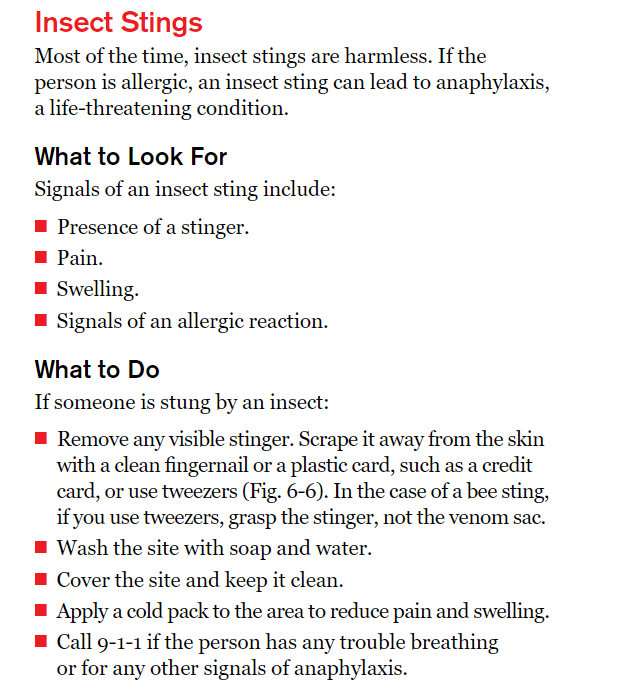

In [16]:
print(textwrap.fill(answer_question("I am allergic to bees and was stung by a bee. What should I do?"), width=80))

If you are allergic to bee stings and have been stung, it's important to act
quickly to prevent a severe allergic reaction, such as anaphylaxis. Here are the
immediate first aid steps you should take:  1. **Remove the Stinger:** If the
stinger is still in your skin, remove it as quickly as possible. You can scrape
it away with a clean fingernail or a plastic card, like a credit card. If you
use tweezers, be careful to grasp the stinger itself and not the venom sac to
avoid squeezing more venom into your skin.  2. **Wash the Area:** Clean the
sting site with soap and water to reduce the risk of infection.  3. **Apply a
Cold Pack:** Use a cold pack or ice wrapped in a cloth to reduce pain and
swelling at the sting site.  4. **Use an Epinephrine Auto-Injector:** If you
have a prescribed epinephrine auto-injector (such as an EpiPen), use it
immediately. Follow the instructions on the device for proper administration.
5. **Call Emergency Services:** Call 9-1-1 or your local emergency number

In [17]:
# Good. Memory worked out. 
print(textwrap.fill(answer_question("What was my first input?"), width=80))

Based on the previous conversation, your first input was: "Triage the victim Rui
Zhang." This input initiated a response detailing the symptoms and suggested
medical care for Rui Zhang, who was experiencing symptoms consistent with
dehydration and possible food poisoning.
